In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, 'Log RMSE:', np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [3]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low  = coef.sort_values(ascending=False).tail(n)
    
    return coef_high, coef_low

def visualize_coefficient(models):
    
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for i, model in enumerate(models):
        
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        axs[i].set_title(model.__class__.__name__ + 'Coefficients', size=25)
        axs[i].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i])
        

In [4]:
def get_avg_rmse_cv(models):
    
    for model in models:
        
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, 
                                             scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        model_name = model.__class__.__name__
        print("\n{0} CV RMSE list: {1}".format(model_name, np.round(rmse_list,3)))
        print("{0} CV AVG RMSE: {1}".format(model_name, np.round(rmse_avg,3)))

In [5]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    model_name = model.__class__.__name__
    print("{0} 5 CV -> Optimal RMSE:{1}, Optimal Alpha:{2}".format(model_name,
                                                                   np.round(rmse,4),
                                                                   grid_model.best_params_))
    

In [6]:
train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')

In [7]:
train_org = pd.read_csv('./data/train.csv')
test_org  = pd.read_csv('./data/test.csv')

In [8]:
print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [9]:
print("data set shape", train.shape)
print("\nfeature dtype\n", train.dtypes.value_counts())
isnull_series = train.isnull().sum()
print("\n null columns and numbers\n", isnull_series[isnull_series>0].sort_values(ascending=False))

data set shape (1460, 81)

feature dtype
 object     43
int64      35
float64     3
dtype: int64

 null columns and numbers
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [10]:
print("data set shape", test.shape)
print("\nfeature dtype\n", test.dtypes.value_counts())
isnull_series = test.isnull().sum()
print("\n null columns and numbers\n", isnull_series[isnull_series>0].sort_values(ascending=False))

data set shape (1459, 80)

feature dtype
 object     43
int64      26
float64    11
dtype: int64

 null columns and numbers
 PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64


In [11]:
isnull_index = isnull_series[isnull_series>500].sort_values(ascending=False).index
print(isnull_index)

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], dtype='object')


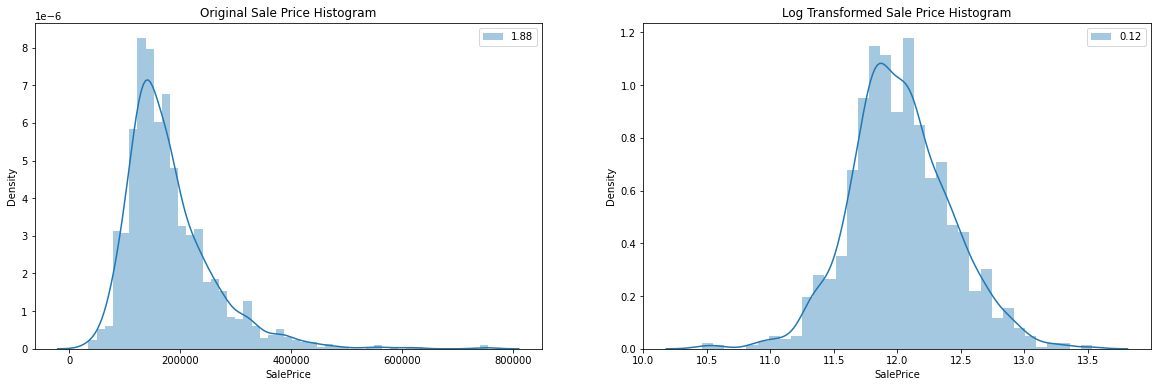

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].set_title('Original Sale Price Histogram')
sns.distplot(train['SalePrice'], ax=ax[0], 
             label="{0:.2f}".format(train['SalePrice'].skew()))
ax[0].legend()

ax[1].set_title('Log Transformed Sale Price Histogram')
sns.distplot(np.log1p(train['SalePrice']), ax=ax[1], 
             label="{0:.2f}".format(np.log1p(train['SalePrice']).skew()))
ax[1].legend()
plt.show()

In [13]:
# Log transform on SalePrice
SalePrice_org = train["SalePrice"]
train['SalePrice'] = np.log1p(train['SalePrice'])

# Drop columns with lots of null values
train.drop(isnull_index, axis=1, inplace=True)
train.drop(['Id'], axis=1, inplace=True)

In [14]:
test.drop(isnull_index, axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [15]:
print(train.shape, test.shape)

(1460, 75) (1459, 74)


In [16]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [17]:
null_column_count = train.isnull().sum()[train.isnull().sum()>0]
print(train.dtypes[null_column_count.index])

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [18]:
null_column_count = test.isnull().sum()[test.isnull().sum()>0]
print(test.dtypes[null_column_count.index])

MSZoning        object
Utilities       object
Exterior1st     object
Exterior2nd     object
MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
KitchenQual     object
Functional      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
SaleType        object
dtype: object


In [19]:
test['SalePrice'] = 0
train_len = len(train)
data = pd.concat([train, test])


print('data shape before get_dummies():', data.shape)
data_ohe = pd.get_dummies(data)
print('data shape after get_dummies() :', data_ohe.shape)

null_column_count = data_ohe.isnull().sum()[data_ohe.isnull().sum()>0]
print(data_ohe.dtypes[null_column_count.index])

data shape before get_dummies(): (2919, 75)
data shape after get_dummies() : (2919, 271)
Series([], dtype: object)


# Modeling

## 1. Linear Regression

In [20]:
train_ohe = data_ohe[:train_len]
test_ohe  = data_ohe[train_len:]

y_target = train_ohe["SalePrice"]
X_features = train_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                    test_size=0.2, random_state=156)

In [21]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression Log RMSE: 0.132
Ridge Log RMSE: 0.128
Lasso Log RMSE: 0.176


[0.13189576579154502, 0.12750846334053012, 0.17628250556471403]

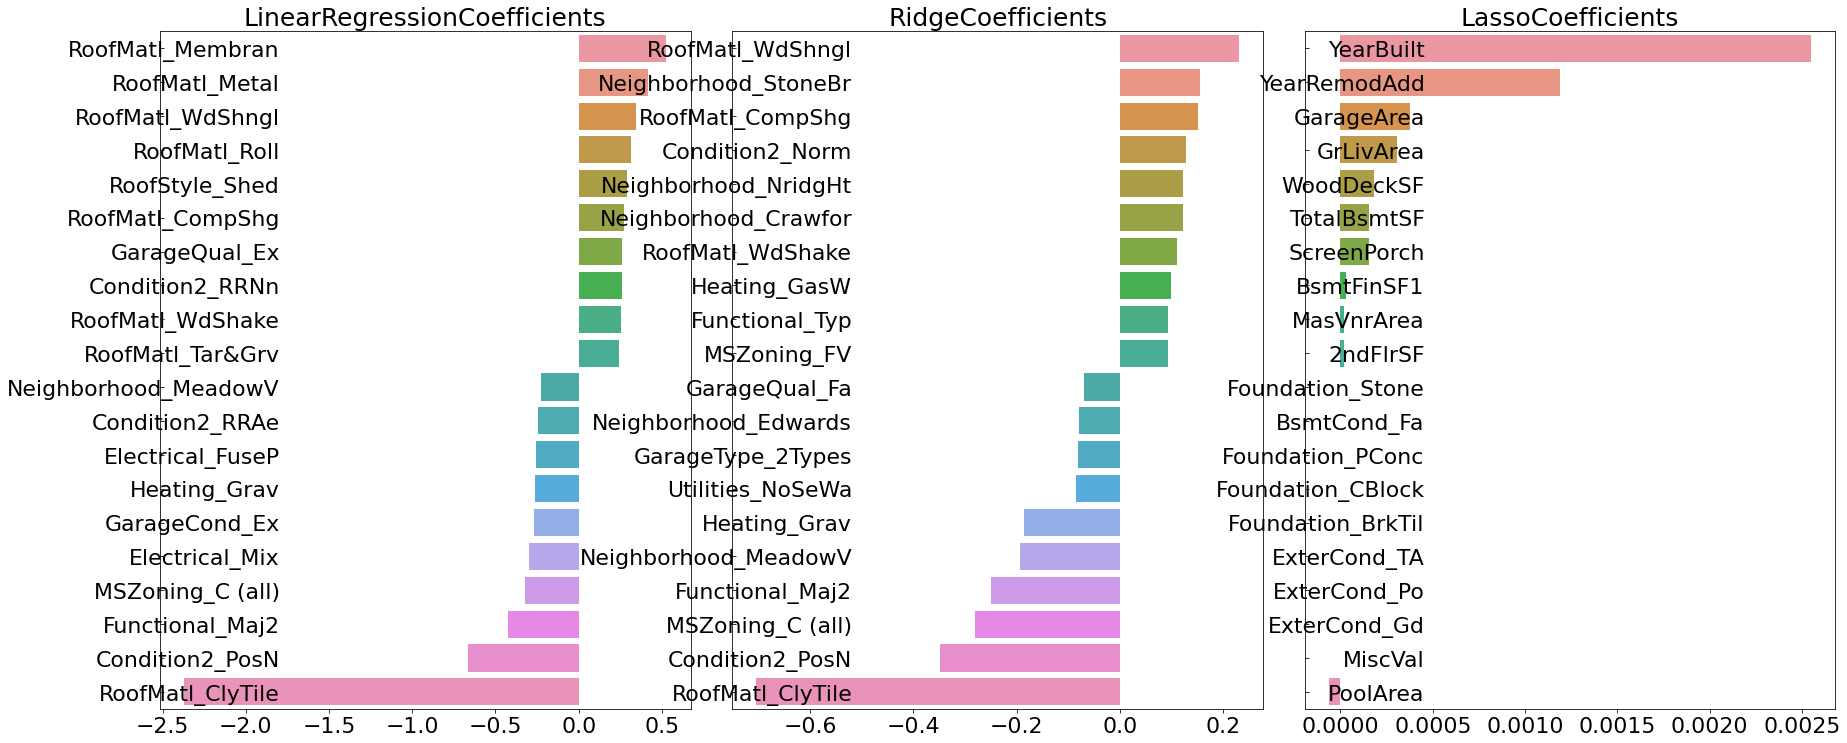

In [22]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [23]:
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE list: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV AVG RMSE: 0.155

Ridge CV RMSE list: [0.117 0.154 0.142 0.117 0.189]
Ridge CV AVG RMSE: 0.144

Lasso CV RMSE list: [0.161 0.204 0.177 0.181 0.265]
Lasso CV AVG RMSE: 0.198


In [24]:
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV -> Optimal RMSE:0.1418, Optimal Alpha:{'alpha': 12}
Lasso 5 CV -> Optimal RMSE:0.142, Optimal Alpha:{'alpha': 0.001}


LinearRegression Log RMSE: 0.132
Ridge Log RMSE: 0.124
Lasso Log RMSE: 0.12


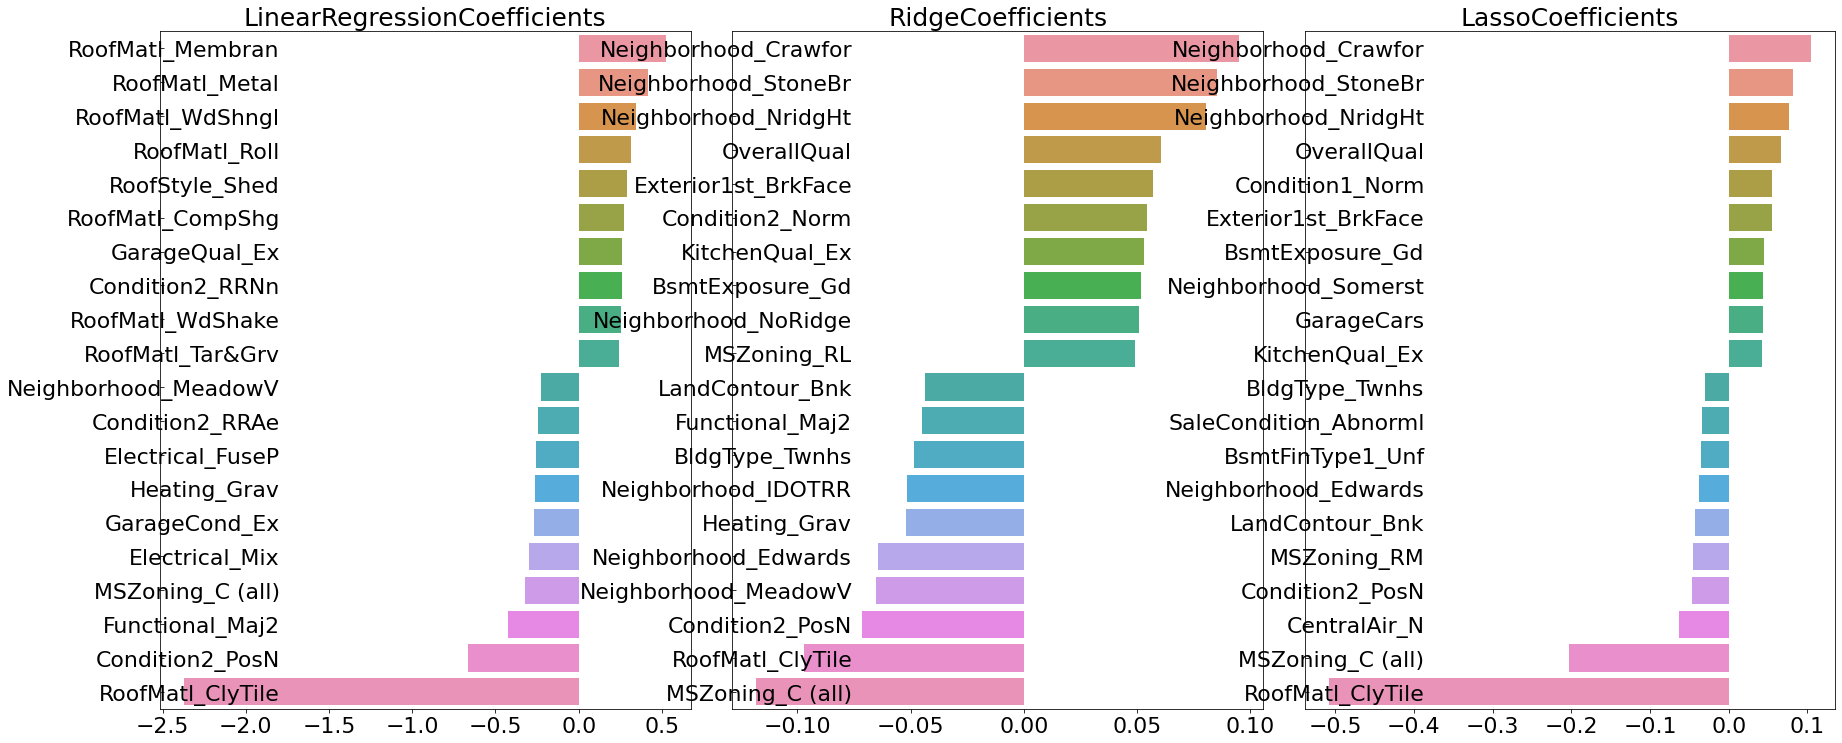

In [25]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

------

In [26]:
from scipy.stats import skew

features_index = train.dtypes[train.dtypes != 'object'].index
skew_features = train[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [27]:
data = pd.concat([train, test])
data[skew_features_top.index] = np.log1p(data[skew_features_top.index])

In [28]:
data_ohe = pd.get_dummies(data)
train_ohe = data_ohe[:train_len]
test_ohe  = data_ohe[train_len:]

y_target = train_ohe['SalePrice']
X_features = train_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, 
                                                    random_state=156)

In [29]:
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV -> Optimal RMSE:0.1275, Optimal Alpha:{'alpha': 10}
Lasso 5 CV -> Optimal RMSE:0.1252, Optimal Alpha:{'alpha': 0.001}


LinearRegression Log RMSE: 0.128
Ridge Log RMSE: 0.122
Lasso Log RMSE: 0.119


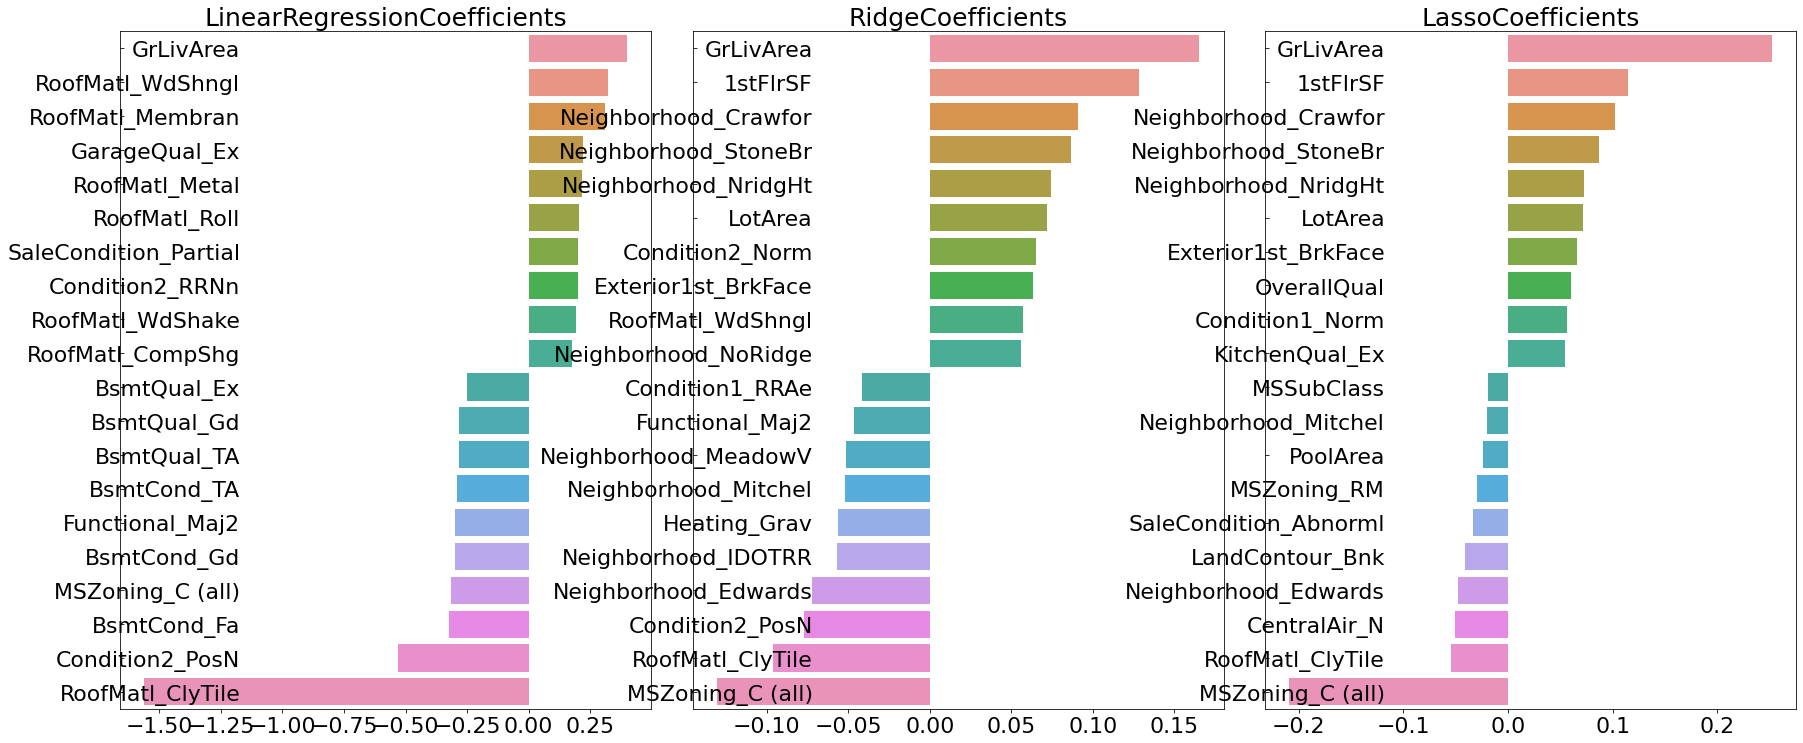

In [30]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

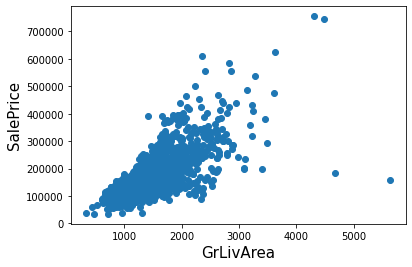

In [31]:
plt.scatter(x=train_org['GrLivArea'], y=train_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [32]:
cond1 = train_ohe['GrLivArea'] > np.log1p(4000)
cond2 = train_ohe['SalePrice'] > np.log1p(500000)
outlier_index = train_ohe[cond1 & cond2].index

print("before outlier detection:", outlier_index.values)
print("before outlier detection :", train_ohe.shape)

train_ohe.drop(outlier_index, axis=0, inplace=True)
print("after outlier detection:", train_ohe.shape)

before outlier detection: [ 691 1182]
before outlier detection : (1460, 271)
after outlier detection: (1458, 271)


In [33]:
y_target = train_ohe['SalePrice']
X_features = train_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, 
                                                    random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV -> Optimal RMSE:0.1272, Optimal Alpha:{'alpha': 10}
Lasso 5 CV -> Optimal RMSE:0.1249, Optimal Alpha:{'alpha': 0.001}


LinearRegression Log RMSE: 0.119
Ridge Log RMSE: 0.107
Lasso Log RMSE: 0.101


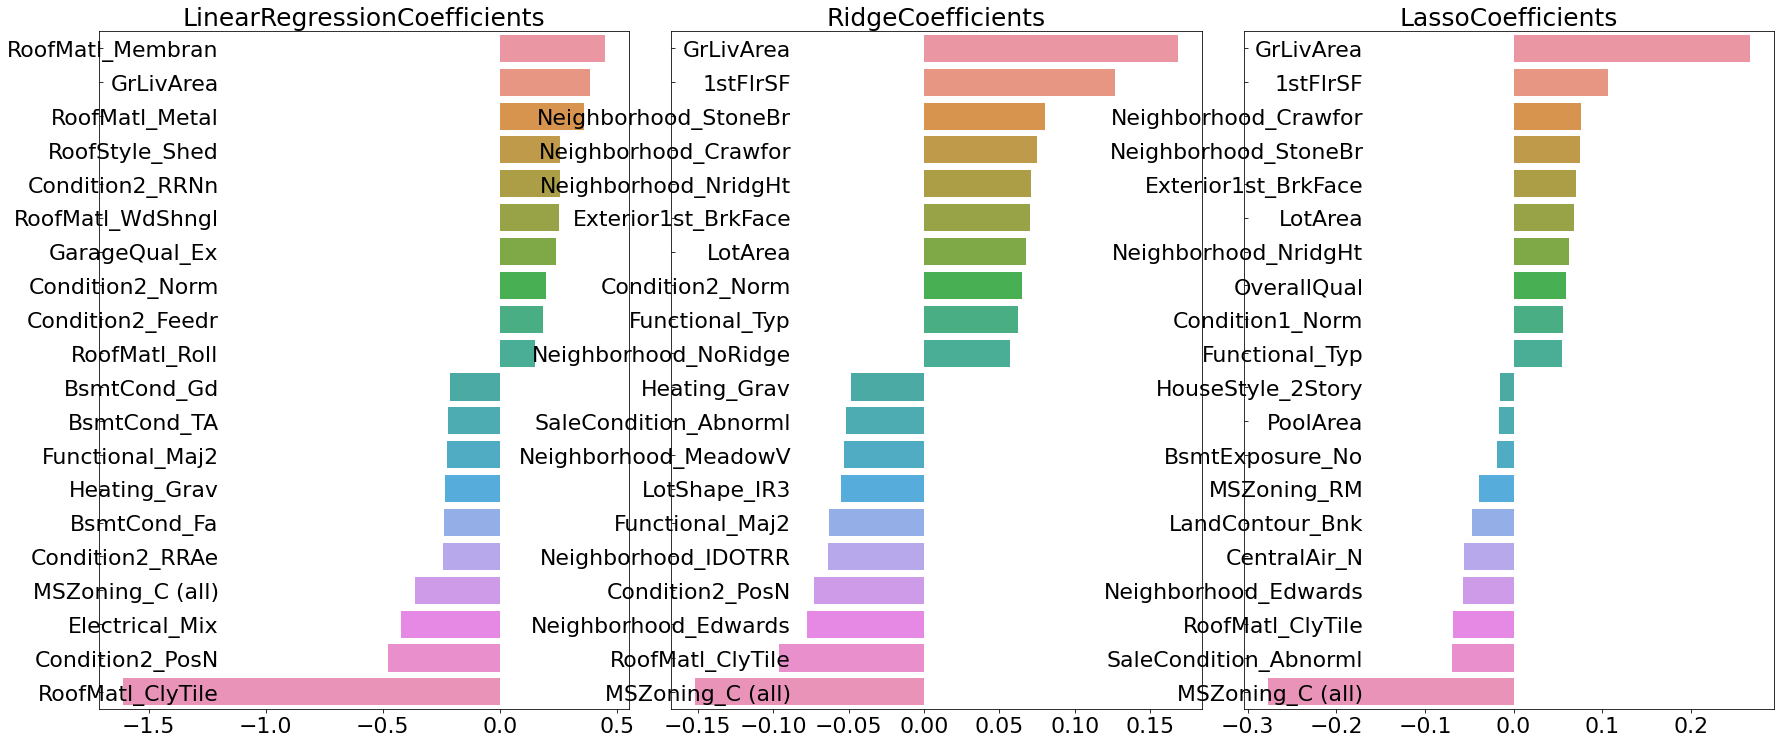

In [34]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [35]:
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_features, y_target)
models = [lasso_reg]
get_rmses(models)

Lasso Log RMSE: 0.093


[0.09268857444673634]

In [36]:
X_features.shape

(1458, 270)

In [37]:
test_ohe.shape

(1459, 271)

In [38]:
test_ohe.drop('SalePrice', axis=1, inplace=True)

In [39]:
predictions = lasso_reg.predict(test_ohe)

In [41]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['SalePrice'] = np.expm1(predictions)

print(submission.shape)
submission.head()

(1459, 2)


,Id,SalePrice
0,1461,120772.996606
1,1462,148893.685213
2,1463,178609.921160
3,1464,198525.827235
4,1465,202977.475175


In [42]:
submission.to_csv("./score_submission_02212021_ver1_ML_Perfect_Guide.csv", index=False)